# **ML2: Versión normalizada MinMax - Ezau Faridh Torres Torres**


**INSTRUCCIONES**: Dado el modelo de transformer entrenado para la tarea 3 y una base de datos de tipo de cambio monedas y precio diario en dólares (USD) del petroleo. Implementar lo siguiente. 

1. Entrenar el modelo (desde cero) para los nuevo datos acorde a la tarea 3. (Este será nuestro Baseline).

2. Usar el modelo preentrenado de la tarea 3 para, mediante un full-tuning, predecir los nuevas secuencias (currencies).

3. Implantar un fine tuning de todo los parámetro de las capas que implique Wx+b en el modelo mediante una estrategia LoRA.

Para los full-tunings de los puntos 2 y 3, correr una o dos épocas.

Comparar ls full +-tunings c.r.a. el modelo del punto 1.

Probar al menos tres valores de rango, r.

# **Descripción General:**

En este script, se implementa el mismo modelo Transformer de la tarea 3 **(no logré guardarlo una vez entrenado debido a que marcaba errores en la capa Positional Enconding, así que, desafortunadamente, en este script tuve que volver a descargar y entrenar aquel modelo)**.

Los datos se comienzan extrayendo tal y como se realizó en la Tarea 2 y 3 (tanto los de las criptomonedas de antes para el primer punto, como los nuevos datos de tasas de cambio a dólar de 6 diferentes monedas y del petróleo). Se adjuntan dos archivos .pkl con los datos usados para entrenar los modelos y para reproducibilidad (es la primera tarea en que los adjunto).

Existe la opción de que cada vez que este script corra la sección de Preparación de Datos, la base de datos se actualice a los datos actuales ya que se inicializa con las últimos 100 horas de los valores de las criptomonedas (al momento). Esto se logra quitando los comentarios largos de la sección de Preparación de Datos

Se descargan los datos como se hizo en la tarea 2 y 3 y se realiza la normalización por banqueo, las monedas elegidas son las mismas:
- Bitcoin
- Ethereum
- Dogecoin
- Cardano
- Litecoin
- Solana
- Polkadot

Los datos para los tipos de cambio de divisas frente al dólar estadounidense son:
- EURUSD=X: Euro (EUR/USD)
- GBPUSD=X: Libra esterlina (GBP/USD)
- JPYUSD=X: Yen japonés (JPY/USD)
- AUDUSD=X: Dólar australiano (AUD/USD)
- CADUSD=X: Dólar canadiense (CAD/USD)
- CHFUSD=X: Franco suizo (CHF/USD)
- CL=F: Futuros de crudo WTI (Petróleo)

Además, se usa el **MinMaxScaler** de **sklearn** debido a la diferencia de magnitudes entre los costos de las monedas (en las divisas no hay tanta variación, excepto en el petróleo).

Todos los modelos implementados usan $64$ neuronas de dimensión latente, $1000$ épocas y un batch size de $32$.

Recordemos que se define un modelo Transformer con Positional Enconding. Utilizando 4 capas de atención y 8 cabezas. El modelo toma entradas escaladas de los precios y tipos de cambio, las transforma mediante bloques de atención, y predice los valores futuros de las criptomonedas. Luego, entrena el modelo y genera predicciones que se desescalan para compararlas con los valores reales.

Para la parte de LoRA, se construye un modelo Transformer con capas LoRA en lugar de capas densas con ayuda de una capa de atención lineal (LoRA) que realiza una transformación lineal de la entrada y luego una multiplicación de matrices de rango $r$ para obtener la salida. Se eligieron los $3$ valores de rango:
- 2
- 8
- 16

Para los modelos con full y fine tuning, se corrieron sólo dos épocas más en cada caso.

Se grafican los resultados para cada caso de predicciones de los modelos Transformer, así como el MSE.

Se dan las conclusiones principales al final del notebook.

# **Librerías**

In [1]:
import yfinance as yf
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error

# **Preparación de Datos**

In [2]:
# Criptomonedas
"""
# Definición de las criptomonedas a analizar
cryptos = ['BTC-USD','ETH-USD','DOGE-USD','ADA-USD','LTC-USD','SOL-USD','DOT-USD']

# Descargar datos
datacryptos = {}
for crypto in cryptos:
    datacryptos[crypto] = yf.download(tickers=crypto, period='1mo', interval='1h')

# Se selecciona el valor de 'Close' para cada criptomoneda
df_cryptos = pd.DataFrame({crypto: datacryptos[crypto]['Close'] for crypto in cryptos})
df_cryptos = df_cryptos.dropna()       # Eliminar filas con valores nulos
# Guardar el DataFrame en un archivo .pkl
df_cryptos.to_pickle('df_cryptos.pkl')
"""

df_cryptos = pd.read_pickle('df_cryptos.pkl') # Cargar el DataFrame desde el archivo .pkl
T = 100+1                                     # Número de pasos en el tiempo
t = 5                                         # Número de pasos en el futuro
df_cryptos = df_cryptos.iloc[-T:]             # Seleccionar los últimos T puntos
n_cryp = df_cryptos.shape[1]                  # Número de criptomonedas (características)
Xcryp = df_cryptos.iloc[:T-t].values          # Primeros T-t puntos
Ycryp = df_cryptos.iloc[T-t:].values          # Últimos t puntos
nombres_columnas_crytos = ['Bitcoin','Ethereum','Dogecoin','Cardano','Litecoin','Solana','Polkadot']

# Escalar los datos
scaler_cryp = MinMaxScaler()
Xcryp_norm = np.expand_dims(scaler_cryp.fit_transform(Xcryp), axis = 0) # Escalar primeros T-t puntos
Ycryp_norm = np.expand_dims(scaler_cryp.transform(Ycryp), axis = 0)     # Escalar últimos t puntos

In [3]:
# Tasas de cambio y precio del petróleo
"""
# Definición de los tipos de cambio y el precio del petróleo
TASAS = ['EURUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'AUDUSD=X', 'CADUSD=X', 'CHFUSD=X', 'CL=F']  # El último es el petróleo (futuros crudo WTI)

# Descargar datos
datatasas = {}
for tasa in TASAS:
    datatasas[tasa] = yf.download(tickers=tasa, period='1mo', interval='1h')

# Seleccionar la columna 'Close' para cada activo
df_tasas = pd.DataFrame({tasa: datatasas[tasa]['Close'] for tasa in TASAS})
df_tasas = df_tasas.dropna()        # Eliminar filas con valores nulos
# Guardar el DataFrame en un archivo .pkl
df_tasas.to_pickle('df_tasas.pkl')
"""

df_tasas = pd.read_pickle('df_tasas.pkl') # Cargar el DataFrame desde el archivo .pkl
T = 100+1                                 # Número de pasos en el tiempo
t = 5                                     # Número de pasos en el futuro
df_tasas = df_tasas.iloc[-T:]             # Seleccionar los últimos T puntos 
n_tasas = df_tasas.shape[1]               # Número de tasa de cambio (características)
Xtasas = df_tasas.iloc[:T-t].values       # Primeros T-t puntos
Ytasas = df_tasas.iloc[T-t:].values       # Últimos t puntos
nombres_columnas_tasas = ['EUR/USD', 'GBP/USD', 'JPY/USD', 'AUD/USD', 'CAD/USD', 'CHF/USD', 'Crudo WTI']

# Escalar los datos
scaler = MinMaxScaler()
Xtasas_norm = np.expand_dims(scaler.fit_transform(Xtasas), axis = 0) # Escalar primeros T-t puntos
Ytasas_norm = np.expand_dims(scaler.transform(Ytasas), axis = 0)     # Escalar últimos t puntos

# **Modelo general del Transformer**

Este es igual al implementado en la tarea 3.

In [4]:
# Parámetros de los modelos
latent_dim = 64   # Dimensión de las representaciones o embeddings que maneja el modelo
n_heads    = 8    # Número de cabezas de atención
num_layers = 4    # Número de capas del modelo
epochs     = 1000 # Número de épocas
batch_size = 32   # Tamaño del lote

In [5]:
# Positional Encoding (Codificación Posicional)
class PositionalEncoding(tf.keras.layers.Layer):
    """
    Codificación posicional para agregar a los embeddings de las secuencias.
    """
    def __init__(self, d_model, max_len=5000):
        """
        d_model: Tamaño de las representaciones o embeddings que maneja el modelo.
        max_len: Longitud máxima de las secuencias de entrada para las que se calculará la codificación posicional.
        """
        super(PositionalEncoding, self).__init__()
        # Generar la codificación posicional en el constructor para todas las posiciones hasta max_len
        self.pos_encoding = self.positional_encoding(max_len, d_model)
    def positional_encoding(self, max_len, d_model):
        """
        Calcula la matriz de codificación posicional para todas las posiciones hasta max_len y para 
        representaciones de tamaño d_model.
        """
        # Crea un vector con las posiciones de 0 a max_len-1 (dimensión [max_len, 1])
        position = np.arange(max_len)[:, np.newaxis]
        # Crea un vector con los factores de división según la fórmula de codificación posicional
        # Cada dimensión usa una escala diferente que depende de la posición
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        # Inicializa la matriz de codificaciones posicionales con ceros (dimensión [max_len, d_model])
        pos_encoding = np.zeros((max_len, d_model))
        # Aplica seno a las posiciones pares (dimensiones 0, 2, 4, ...) 
        pos_encoding[:,0::2] = np.sin(position * div_term)
        # Aplica coseno a las posiciones impares (dimensiones 1, 3, 5, ...)
        pos_encoding[:,1::2] = np.cos(position * div_term)
        # Agrega una dimensión extra para que sea compatible con las entradas del modelo (dimensión [1, max_len, d_model])
        pos_encoding = pos_encoding[np.newaxis, ...]
        # Convierte la matriz de codificación a tipo TensorFlow con formato float32
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        """
        Agregar la codificación posicional a la entrada.
        inputs: Tensor de entrada con forma (batch_size, seq_len, d_model).
        """
        seq_len = tf.shape(inputs)[1]  # Obtener la longitud de la secuencia de entrada
        # Suma la codificación posicional a los embeddings originales (limitado a la longitud real de la secuencia)
        return inputs + self.pos_encoding[:, :seq_len, :]

# Construcción del modelo Transformer
def build_transformer(n_features: int, latent_dim: int, n_heads: int, num_layers: int):
    """
    Construye un modelo Transformer para la predicción de series temporales.

    Parameters
    ----------
    n_features : int
        Número de características en los datos de entrada.
    latent_dim : int
        Dimensión de las representaciones o embeddings que maneja el modelo.
    n_heads : int
        Número de cabezas de atención.
    num_layers : int
        Número de capas del modelo.
    
    Returns
    -------
    tf.keras.Model
        Modelo Transformer para la predicción de series temporales.
    """
    inputs = Input(shape=(None, n_features))
    # Embedding
    x = Dense(latent_dim)(inputs)
    # Positional Encoding
    x = PositionalEncoding(latent_dim)(x)
    # Transformer blocks
    for _ in range(num_layers):
        attention_output = MultiHeadAttention(num_heads=n_heads, key_dim=latent_dim)(x, x)
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
        feed_forward_output = Dense(latent_dim, activation='relu')(attention_output)
        x = LayerNormalization(epsilon=1e-6)(feed_forward_output + attention_output)
    
    # Output layer
    outputs = Dense(n_features)(x[:, -t:, :])
    return Model(inputs, outputs)

# **1.- Entrenar el modelo (desde cero) para los nuevo datos acorde a la tarea 3. (Este será nuestro Baseline).**

Se entrena el modelo en los datos de tasas de cambio y se toman las predicciones logradas.

In [6]:
# Contrucción del modelo para las Tasas de Cambio
Transf_Tasas = build_transformer(n_tasas, latent_dim, n_heads, num_layers)
Transf_Tasas.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
Transf_Tasas.summary()

# Entrenamiento
history_baseline = Transf_Tasas.fit(Xtasas_norm, Ytasas_norm, epochs=epochs, batch_size=batch_size, verbose=1)

# Predicciones
predicciones_baseline = Transf_Tasas.predict(Xtasas_norm)
predicciones_baseline = scaler.inverse_transform(predicciones_baseline[0])

# Comparar las predicciones con los valores reales y calcular el MSE
mse_baseline = mean_squared_error(Ytasas, predicciones_baseline)
print('MSE para modelo entrenado desde cero:', mse_baseline)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 64)  │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, None, 64)  │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 64)  │          0 │ dense_2[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_4[0][0]     

 Total params: 549,319 (2.10 MB)

 Trainable params: 549,319 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.1592 - mae: 1.2186
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0265 - mae: 1.1713
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8379 - mae: 0.7668
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1803 - mae: 0.3463
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1340 - mae: 0.2817
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2182 - mae: 0.4177
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2136 - mae: 0.4010
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1476 - mae: 0.3285
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0962 - mae: 0.2463
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0645 - mae: 0.1949
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0444 - mae: 0.1603
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0403 - mae: 0.1658
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 

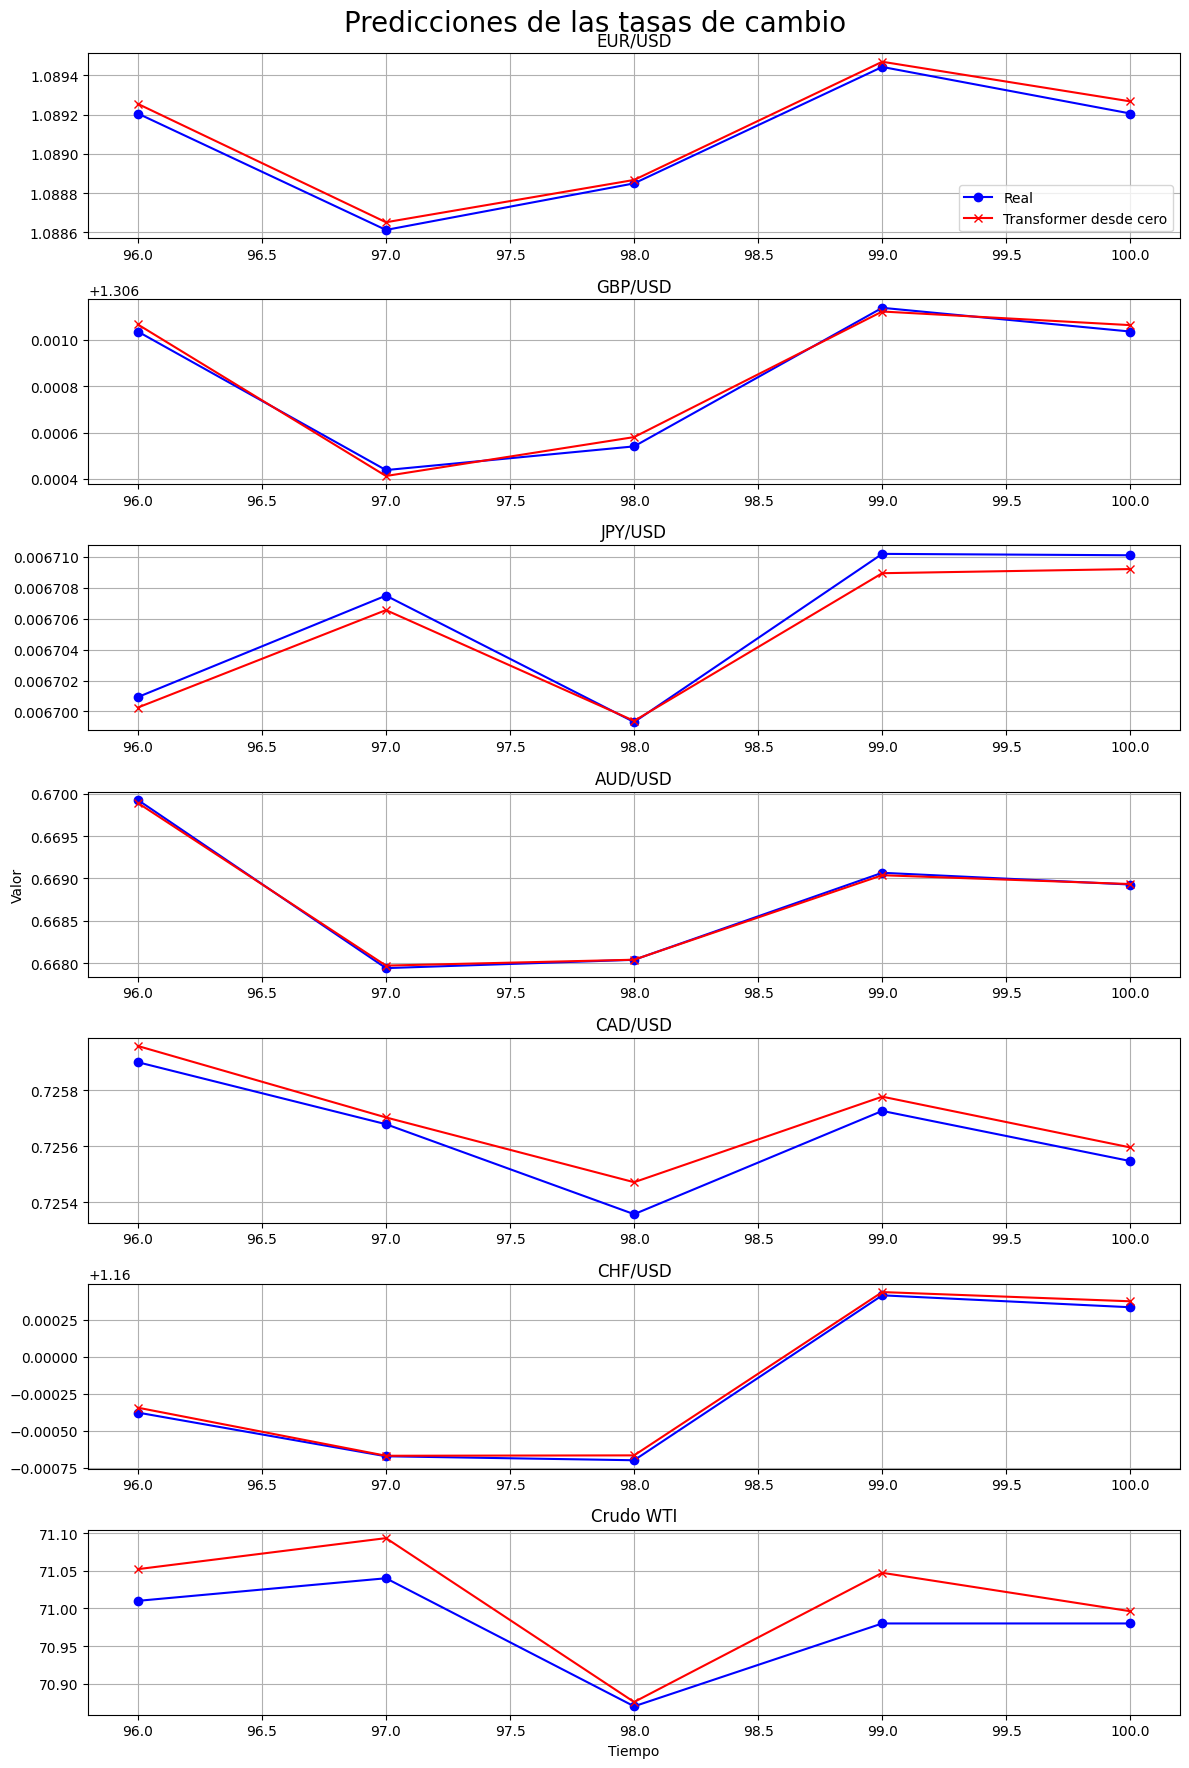

In [7]:
# Graficar los resultados
plt.figure(figsize=(12,18))
plt.suptitle('Predicciones de las tasas de cambio', fontsize=20)
for i in range(n_tasas):
    plt.subplot(n_tasas, 1, i+1)
    plt.plot(range(T-t,T), Ytasas[:,i], label='Real', marker='o', c='blue')
    plt.plot(range(T-t,T), predicciones_baseline[:,i], label='Transformer desde cero', marker='x', c='red')
    plt.title(nombres_columnas_tasas[i])
    plt.grid(True)
    if i == n_tasas - 1:
        plt.xlabel('Tiempo')
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylabel('Valor')
plt.tight_layout()
plt.show()

# **2.- Full-Tuning:** Usar el modelo preentrenado de la tarea 3 para, mediante un full-tuning, predecir los nuevas secuencias (currencies).

Como no logré guardar el modelo pre entrenado de la tarea 3, a continuación se hace un re entrenamiento con los datos actuales.

## **2.1.-** Se carga el modelo "pre-entrenado" de la tarea 3

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9487 - mae: 0.8144
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2763 - mae: 0.8875
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1574 - mae: 0.9413
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2177 - mae: 0.3668
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1603 - mae: 0.3304
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2447 - mae: 0.4229
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1392 - mae: 0.3442
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1207 - mae: 0.2960
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1597 - mae: 0.3569
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1269 - mae: 0.3080
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0553 - mae: 0.2000
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0223 - mae: 0.1137
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 

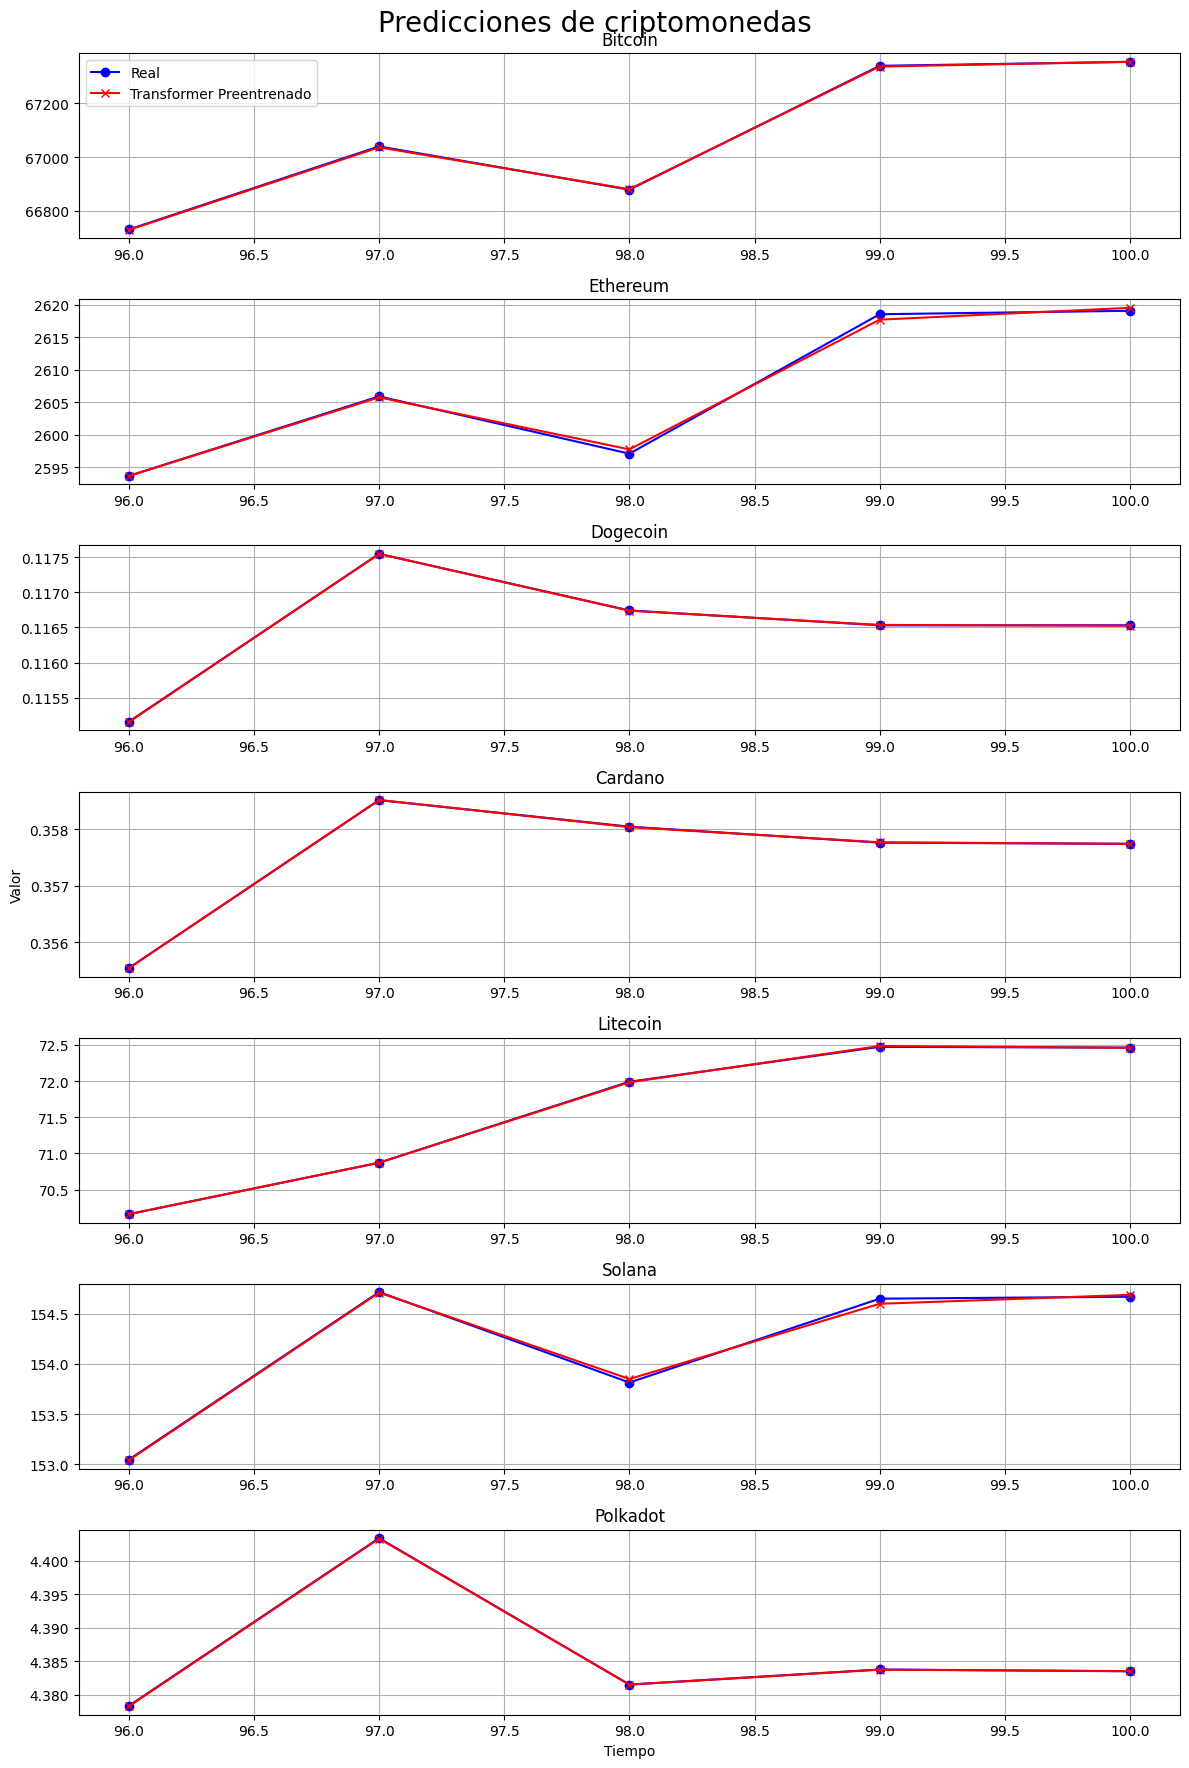

In [8]:
# Contrucción del modelo para criptomonedas
Transf_Pretrained = build_transformer(n_cryp, latent_dim, n_heads, num_layers)
Transf_Pretrained.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Entrenamiento
historyTransformer_cryp = Transf_Pretrained.fit(Xcryp_norm, Ycryp_norm, epochs=epochs, batch_size=batch_size, verbose=1)

# Predicciones
predicciones_pretrained = Transf_Pretrained.predict(Xcryp_norm)
predicciones_pretrained = scaler_cryp.inverse_transform(predicciones_pretrained[0])

# Comparar las predicciones con los valores reales y calcular el MSE
msePretrained = mean_squared_error(Ycryp, predicciones_pretrained)
print(f"MSE para modelo Transformer Preentrenado: {msePretrained}")

# Graficar los resultados
plt.figure(figsize=(12,18))
plt.suptitle('Predicciones de criptomonedas', fontsize=20)
for i in range(n_cryp):
    plt.subplot(n_cryp, 1, i+1)
    plt.plot(range(T-t,T), Ycryp[:,i], label='Real', marker='o', c='blue')
    plt.plot(range(T-t,T), predicciones_pretrained[:,i], label='Transformer Preentrenado', marker='x', c='red')
    plt.title(nombres_columnas_crytos[i])
    plt.grid(True)
    if i == n_cryp - 1:
        plt.xlabel('Tiempo')
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylabel('Valor')
plt.tight_layout()
plt.show()

## **2.2.-** Se realiza el full-tuning con dos épocas adicionales al modelo entrenado para las criptomonedas.

In [9]:
# "Transf_Pretrained" es el modelo preentrenado
epochs_full_tuning = 2

# Volver a compilar el modelo
Transf_Pretrained.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
Transf_Pretrained.summary()

# Ajustar con los nuevos datos (full-tuning) con 2 épocas
history_full_tuning = Transf_Pretrained.fit(Xtasas_norm, Ytasas_norm, epochs = epochs_full_tuning, batch_size=batch_size, verbose=1)

# Predecir para los nuevos datos
predicciones_full_tuning = Transf_Pretrained.predict(Xtasas_norm)
predicciones_full_tuning = scaler.inverse_transform(predicciones_full_tuning[0])

# Calcular el MSE
mse_full_tuning = mean_squared_error(Ytasas, predicciones_full_tuning)
print(f"MSE para modelo con full-tuning: {mse_full_tuning}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, None, 64)  │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ dense_6[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, None, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, None, 64)  │          0 │ dense_7[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, None, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, None, 64)  │          0 │ dense_8[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_12[0][0]    

 Total params: 549,319 (2.10 MB)

 Trainable params: 549,319 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3952 - mae: 0.5525
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2310 - mae: 0.3639
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
MSE para modelo con full-tuning: 0.29796745242718886


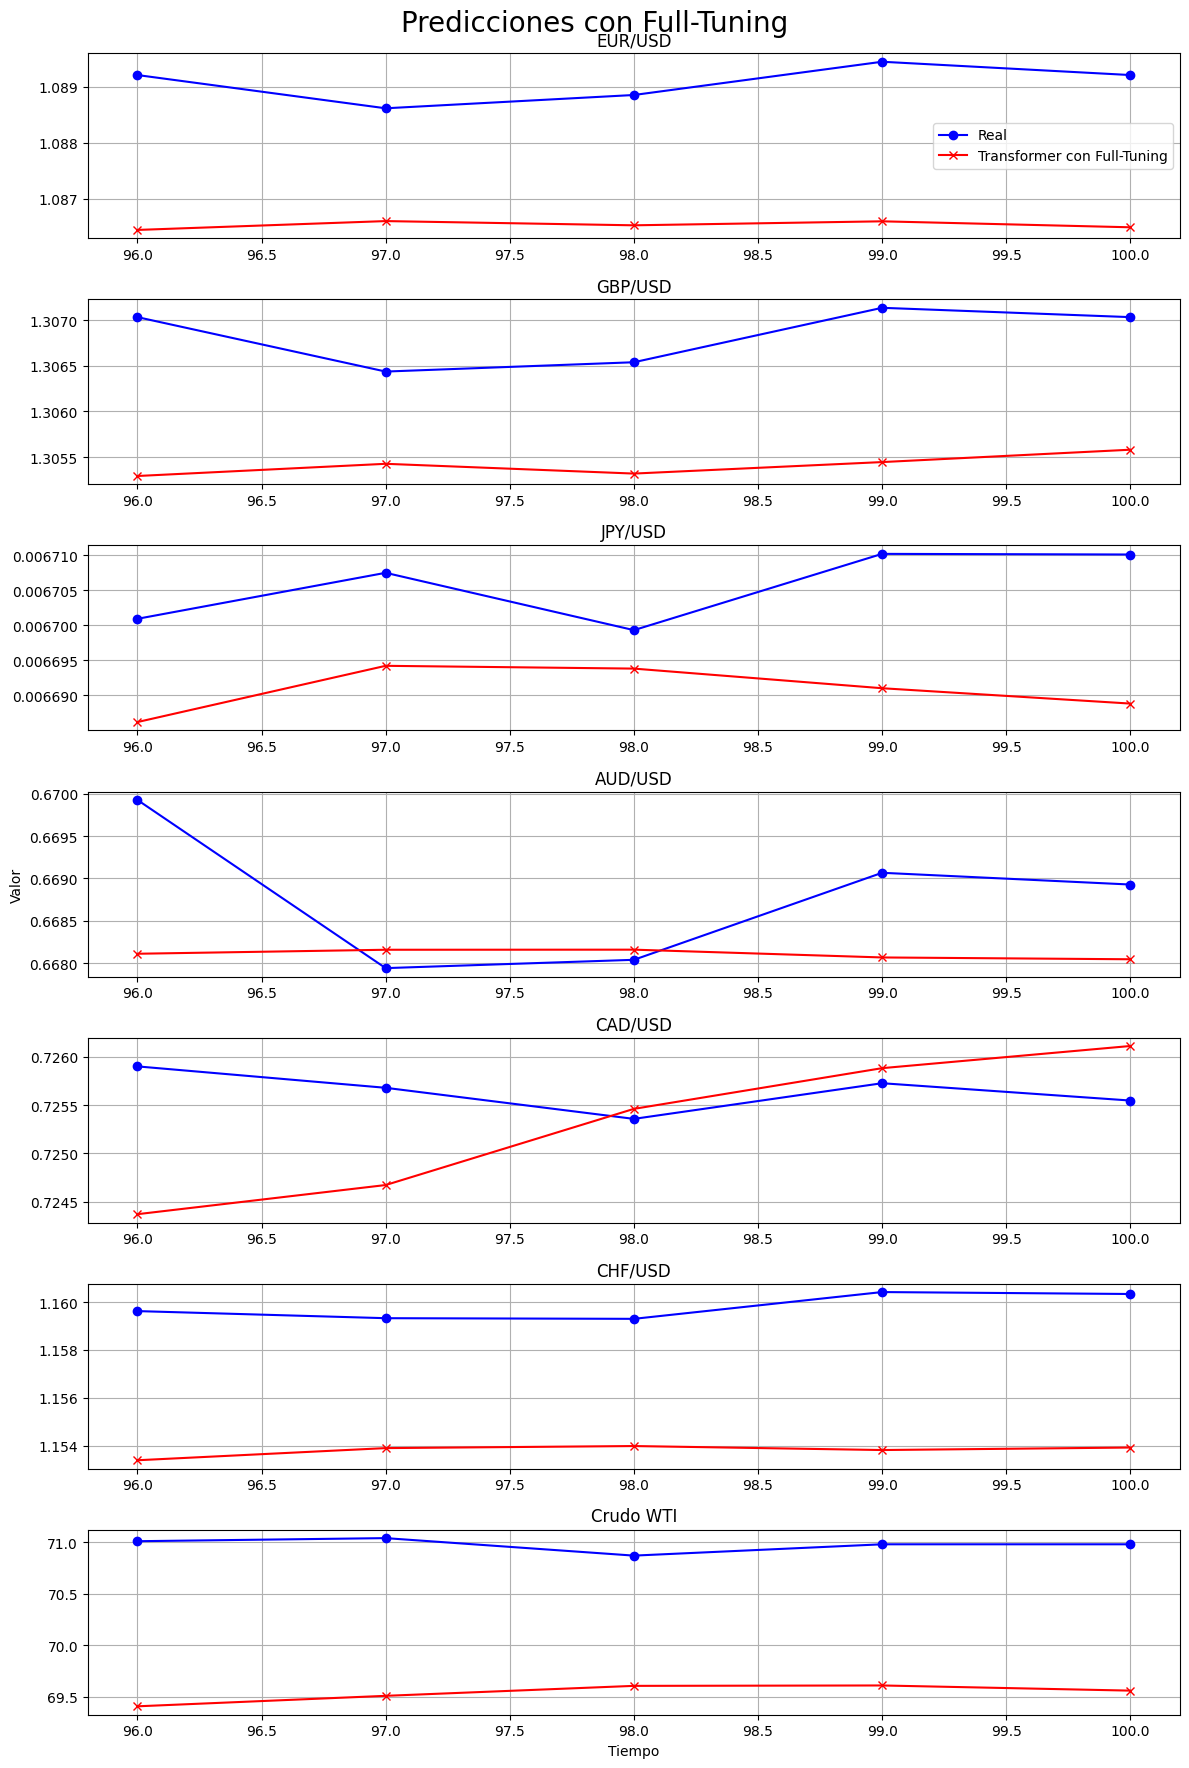

In [10]:
# Graficar los resultados
plt.figure(figsize=(12,18))
plt.suptitle('Predicciones con Full-Tuning', fontsize=20)
for i in range(n_tasas):
    plt.subplot(n_tasas, 1, i+1)
    plt.plot(range(T-t,T), Ytasas[:,i], label='Real', marker='o', c='blue')
    plt.plot(range(T-t,T), predicciones_full_tuning[:,i], label='Transformer con Full-Tuning', marker='x', c='red')
    plt.title(nombres_columnas_tasas[i])
    plt.grid(True)
    if i == n_tasas - 1:
        plt.xlabel('Tiempo')
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylabel('Valor')
plt.tight_layout()
plt.show()

# **3.- Implantar un fine tuning de todo los parámetro de las capas que implique Wx+b en el modelo mediante una estrategia LoRA.**

Se construye un modelo Transformer con capas LoRA en lugar de capas densas con ayuda de una capa de atención lineal (LoRA) que realiza una transformación lineal de la entrada y luego una multiplicación de matrices de rango $r$ para obtener la salida. Se eligieron los $3$ valores de rango:
- 2
- 8
- 16

## **3.1.- Capa LoRA** 

In [11]:
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, input_dim: int, output_dim: int, r: int):
        """
        Capa de atención lineal (LoRA) que realiza una transformación lineal de la entrada
        y luego una multiplicación de matrices de rango r para obtener la salida.

        Parameters
        ----------
        input_dim : int
            Número de características en los datos de entrada.
        output_dim : int
            Número de características en los datos de salida.
        r : int
            Rango de las matrices.
        """
        super(LoRALayer, self).__init__()
        self.r = r
        self.A = self.add_weight(shape=(input_dim, r), initializer="random_normal", trainable=True)
        self.B = self.add_weight(shape=(r, output_dim), initializer="zeros", trainable=True)

    def call(self, inputs):
        """
        Realiza la transformación lineal y la multiplicación de matrices de rango r.
        """
        return tf.matmul(inputs, self.A) @ self.B

## **3.2.- Modelo Transformer con LoRA** 

In [12]:
# Añadir LoRA en las capas que contienen Wx + b
def build_transformer_with_lora(n_features: int, latent_dim: int, n_heads: int, num_layers: int, r: int):
    """
    Construye un modelo Transformer con capas LoRA en lugar de capas densas.

    Parameters
    ----------
    n_features : int
        Número de características en los datos de entrada.
    latent_dim : int 
        Dimensión de las representaciones o embeddings que maneja el modelo.
    n_heads : int
        Número de cabezas de atención.
    num_layers : int
        Número de capas del modelo.
    r : int 
    Rango de la multiplicación de matrices en la capa

    Returns:
    model : tf.keras.Model
        Modelo Transformer con capas LoRA.
    """
    inputs = Input(shape=(None, n_features))
    x = Dense(latent_dim)(inputs)         # Embedding
    x = PositionalEncoding(latent_dim)(x) # Positional Encoding
    for _ in range(num_layers): # Transformer blocks
        attention_output = MultiHeadAttention(num_heads=n_heads, key_dim=latent_dim)(x, x)
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
        lora_layer = LoRALayer(latent_dim, latent_dim, r) # Aplicar LoRA en la capa densa
        feed_forward_output = lora_layer(attention_output)
        x = LayerNormalization(epsilon=1e-6)(feed_forward_output + attention_output)
    
    outputs = Dense(n_features)(x[:, -t:, :]) # Output layer
    return Model(inputs, outputs)

In [13]:
# Valores para el rango r.
r1 = 2
r2 = 8
r3 = 16
epochsLoRa = 2 # Número de épocas para modelos con LoRA

# Contrucción de los modelos con LoRA
Transf_LoRA1 = build_transformer_with_lora(n_tasas, latent_dim, n_heads, num_layers, r = r1)
Transf_LoRA2 = build_transformer_with_lora(n_tasas, latent_dim, n_heads, num_layers, r = r2)
Transf_LoRA3 = build_transformer_with_lora(n_tasas, latent_dim, n_heads, num_layers, r = r3)
Transf_LoRA1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
Transf_LoRA2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
Transf_LoRA3.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
Transf_LoRA1.summary()
Transf_LoRA2.summary()
Transf_LoRA3.summary()

# Entrenamiento
history_fine_tuning1 = Transf_LoRA1.fit(Xtasas_norm, Ytasas_norm, epochs=epochsLoRa, batch_size=batch_size, verbose=1)
history_fine_tuning2 = Transf_LoRA2.fit(Xtasas_norm, Ytasas_norm, epochs=epochsLoRa, batch_size=batch_size, verbose=1)
history_fine_tuning3 = Transf_LoRA3.fit(Xtasas_norm, Ytasas_norm, epochs=epochsLoRa, batch_size=batch_size, verbose=1)

# Predicciones
predicciones_fine_tuning1 = Transf_LoRA1.predict(Xtasas_norm)
predicciones_fine_tuning2 = Transf_LoRA2.predict(Xtasas_norm)
predicciones_fine_tuning3 = Transf_LoRA3.predict(Xtasas_norm)
predicciones_fine_tuning1 = scaler.inverse_transform(predicciones_fine_tuning1[0])
predicciones_fine_tuning2 = scaler.inverse_transform(predicciones_fine_tuning2[0])
predicciones_fine_tuning3 = scaler.inverse_transform(predicciones_fine_tuning3[0])

# Comparar las predicciones con los valores reales y calcular el MSE
mse_fine_tuning1 = mean_squared_error(Ytasas, predicciones_fine_tuning1)
mse_fine_tuning2 = mean_squared_error(Ytasas, predicciones_fine_tuning2)
mse_fine_tuning3 = mean_squared_error(Ytasas, predicciones_fine_tuning3)
print(f"MSE para modelo con LoRA (r={r1}): {mse_fine_tuning1}")
print(f"MSE para modelo con LoRA (r={r2}): {mse_fine_tuning2}")
print(f"MSE para modelo con LoRA (r={r3}): {mse_fine_tuning3}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, None, 64)  │        512 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ dense_12[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lo_ra_layer         │ (None, None, 64)  │        256 │ layer_normalizat… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, None, 64)  │          0 │ lo_ra_layer[0][0… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lo_ra_layer_1       │ (None, None, 64)  │        256 │ layer_normalizat… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, None, 64)  │          0 │ lo_ra_layer_1[0]… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat

 Total params: 533,703 (2.04 MB)

 Trainable params: 533,703 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, None, 64)  │        512 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ dense_14[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lo_ra_layer_4       │ (None, None, 64)  │      1,024 │ layer_normalizat… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, None, 64)  │          0 │ lo_ra_layer_4[0]… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lo_ra_layer_5       │ (None, None, 64)  │      1,024 │ layer_normalizat… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, None, 64)  │          0 │ lo_ra_layer_5[0]… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat

 Total params: 536,775 (2.05 MB)

 Trainable params: 536,775 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, None, 64)  │        512 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ dense_16[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lo_ra_layer_8       │ (None, None, 64)  │      2,048 │ layer_normalizat… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, None, 64)  │          0 │ lo_ra_layer_8[0]… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lo_ra_layer_9       │ (None, None, 64)  │      2,048 │ layer_normalizat… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, None, 64)  │          0 │ lo_ra_layer_9[0]… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_35[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat

 Total params: 540,871 (2.06 MB)

 Trainable params: 540,871 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.0545 - mae: 1.1419
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4259 - mae: 1.0255
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.7120 - mae: 1.4849
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6615 - mae: 0.6006
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.8349 - mae: 1.1497
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1300 - mae: 0.8677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
MSE para modelo con LoRA (r=2): 1.4611759641582782
MSE para modelo con LoRA (r=8): 5.914297911616997
MSE para modelo con LoRA (r=16): 0.3992875836025713


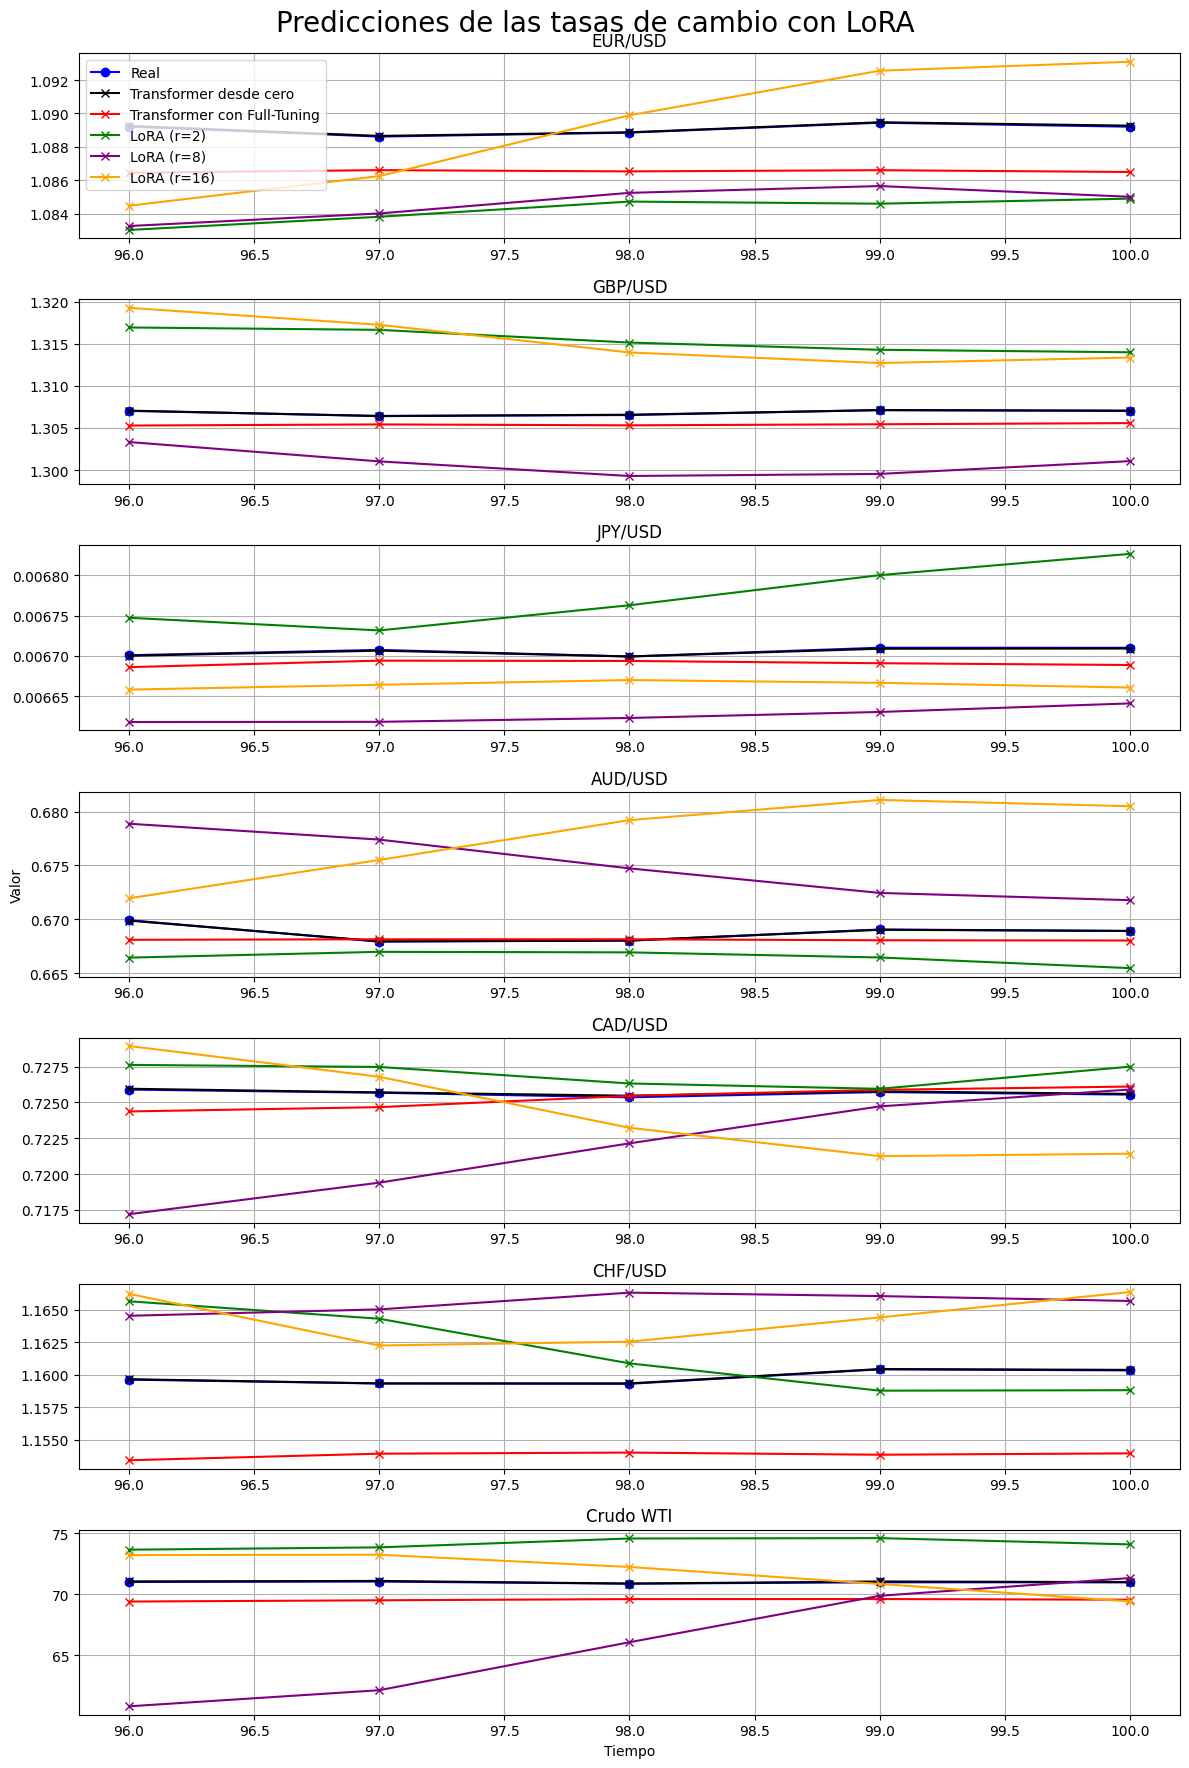

In [14]:
# Graficar los resultados
plt.figure(figsize=(12,18))
plt.suptitle('Predicciones de las tasas de cambio con LoRA', fontsize=20)
for i in range(n_tasas):
    plt.subplot(n_tasas, 1, i+1)
    plt.plot(range(T-t,T), Ytasas[:,i], label='Real', marker='o', c='blue')
    plt.plot(range(T-t,T), predicciones_baseline[:,i], label='Transformer desde cero', marker='x', c='black')
    plt.plot(range(T-t,T), predicciones_full_tuning[:,i], label='Transformer con Full-Tuning', marker='x', c='red')
    plt.plot(range(T-t,T), predicciones_fine_tuning1[:,i], label=f"LoRA (r={r1})", marker='x', c='green')
    plt.plot(range(T-t,T), predicciones_fine_tuning2[:,i], label=f"LoRA (r={r2})", marker='x', c='purple')
    plt.plot(range(T-t,T), predicciones_fine_tuning3[:,i], label=f"LoRA (r={r3})", marker='x', c='orange')
    plt.title(nombres_columnas_tasas[i])
    plt.grid(True)
    if i == n_tasas - 1:
        plt.xlabel('Tiempo')
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylabel('Valor')
plt.tight_layout()
#plt.savefig("predicciones.pdf", bbox_inches = 'tight', pad_inches = 0.4, dpi = 500, format = 'pdf', transparent = True)

plt.show()

In [16]:
# MSE para cada modelo:
print(f"MSE para modelo entrenado desde cero : {mse_baseline}")
print(f"MSE para modelo con full-tuning      : {mse_full_tuning}")
print(f"MSE para modelo con LoRA (r={r1})       : {mse_fine_tuning1}")
print(f"MSE para modelo con LoRA (r={r2})       : {mse_fine_tuning2}")
print(f"MSE para modelo con LoRA (r={r3})      : {mse_fine_tuning3}")

MSE para modelo entrenado desde cero : 0.00026933972883010353
MSE para modelo con full-tuning      : 0.29796745242718886
MSE para modelo con LoRA (r=2)       : 1.4611759641582782
MSE para modelo con LoRA (r=8)       : 5.914297911616997
MSE para modelo con LoRA (r=16)      : 0.3992875836025713


# **Conclusiones**

En este experimento, se evaluaron diversas estrategias de ajuste para predecir el comportamiento de tasas de cambio a partir del modelo preentrenado en datos de criptomonedas de la tarea 3. Se aplicó full tuning, ajustando completamente el modelo con los nuevos datos de tasas de cambio durante solo dos épocas adicionales. Sin embargo, los resultados obtenidos indicaron que esta estrategia no fue tan efectiva como entrenar un modelo desde cero, específicamente diseñado para las tasas de cambio.

Por otro lado, se exploró el uso de LoRA (Low-Rank Adaptation), con tres diferentes valores de rango (r = 2, r = 8, r = 16), ajustando los modelos con la misma cantidad de épocas (2). Aunque el uso de LoRA no mejoró el desempeño respecto al modelo preentrenado ni cuando el rango es mayor, los resultados tampoco superaron al modelo entrenado desde cero. Se observó que, al aumentar el rango de LoRA, el desempeño fue ligeramente mejor, lo que sugiere que un rango mayor permite una mejor adaptación de los modelos a los nuevos datos.

Finalmente, se llevó a cabo un experimento adicional en el que los modelos fueron entrenados durante 100 épocas, tanto con LoRA como desde cero. Los resultados fueron significativamente superiores en ambos casos, mostrando que la cantidad de épocas de entrenamiento es un factor crucial para mejorar la precisión de las predicciones en el contexto de tasas de cambio. Este hallazgo subraya que un mayor ajuste, tanto en términos de número de épocas como en la correcta selección del rango en LoRA, es esencial para obtener mejores resultados en este tipo de tareas de predicción financiera.

En resumen, los resultados sugieren que, si bien LoRA puede ofrecer un ajuste eficiente con pocas épocas, un entrenamiento completo desde cero con un número considerable de épocas sigue siendo la estrategia más efectiva para adaptar modelos de criptomonedas a la predicción de tasas de cambio.